In [1]:
from PIL import Image
import numpy as np
import cupy as cp
from scipy import misc
from matplotlib import pyplot, cm
from IPython.display import display

In [2]:
def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice with given pitch."""
    indices = cp.arange(res)
    return (0.5 - res/2 + indices) * pitch

def compute_display_pitch(z_r, z_a, z_b, z_near, z_far, xi_r):
    """Return necessary pitch on each display plane to reproduce given retinal frequency inside given depth interval."""
    k = z_near * (2 * z_b - z_a) - z_a * z_b
    xi_a = z_r * xi_r * (z_b * (z_near/z_far) - z_near) / k
    xi_b = z_r * xi_r * (0.5*z_a * (1 + z_near/z_far) - z_near) / k
    return (0.5/xi_a, 0.5/xi_b)

def create_filter(omega_a, omega_b, z_r, z_a, z_b, z_near, z_far, xi_r):
    """Return a low-pass filter defined from near and far focus distance and maximum retina frequency."""
    mask_near = ((z_near - z_a) * omega_a + (z_near - z_b) * omega_b) < 0
    mask_far = (z_far * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) > 0
    mask_r = cp.abs(z_a * omega_a + z_b * omega_b) > -z_r * xi_r
    return cp.logical_not(cp.logical_or(cp.logical_xor(mask_near, mask_far), mask_r)) * 1.0

def display_image(values, color_map=None):
    """Display an array of values as an image using a color map."""
    color_values = cm.get_cmap(color_map)(values/np.amax(values))
    uint8_values = (color_values * 255).astype(np.uint8)
    display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

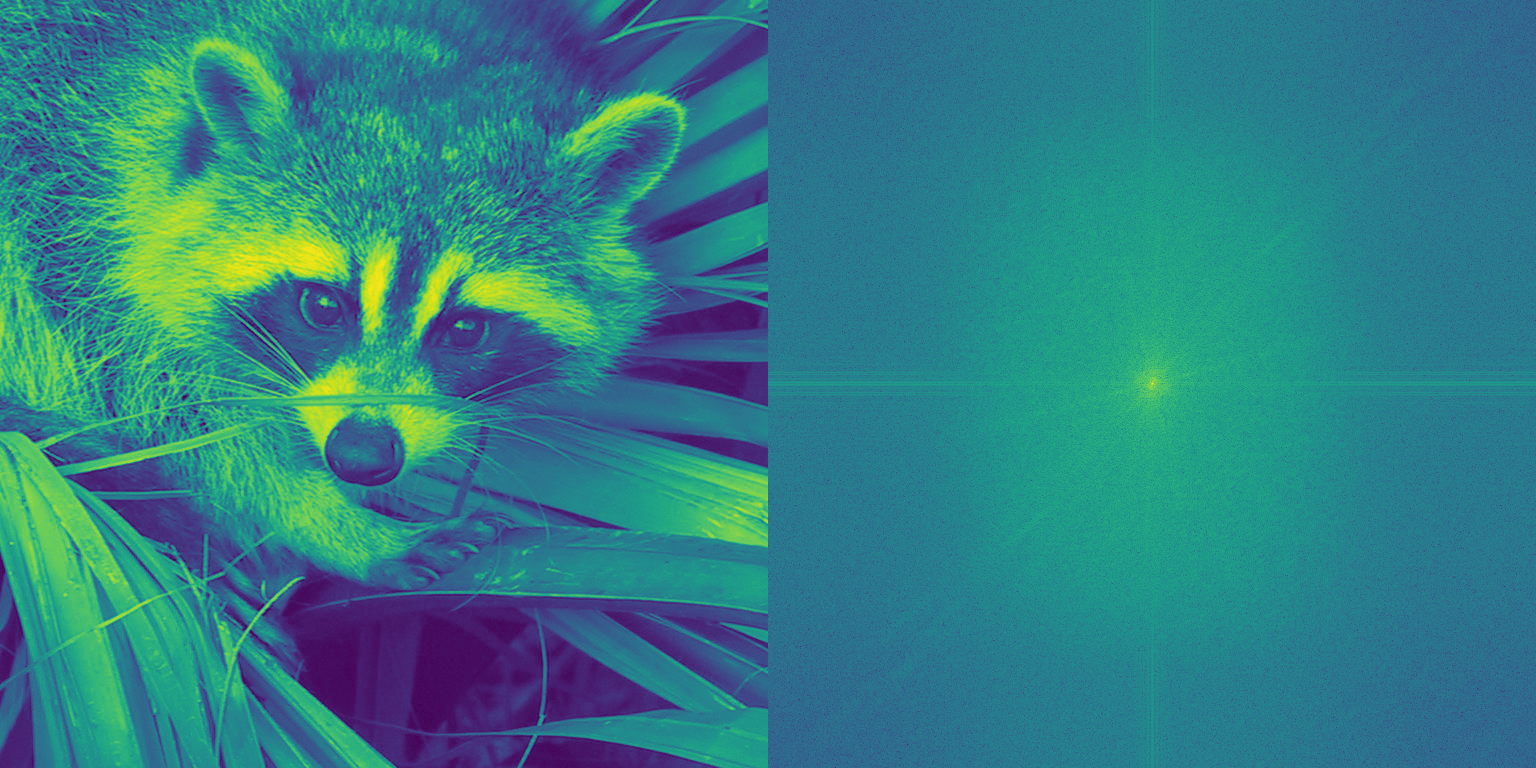

In [3]:
primal = cp.asarray(misc.face(True).T[-768:, ::-1])
dual = cp.fft.fft2(primal)

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual))+1.0)
display_image(cp.vstack((primal/cp.amax(primal), spectrum/cp.amax(spectrum))).get())

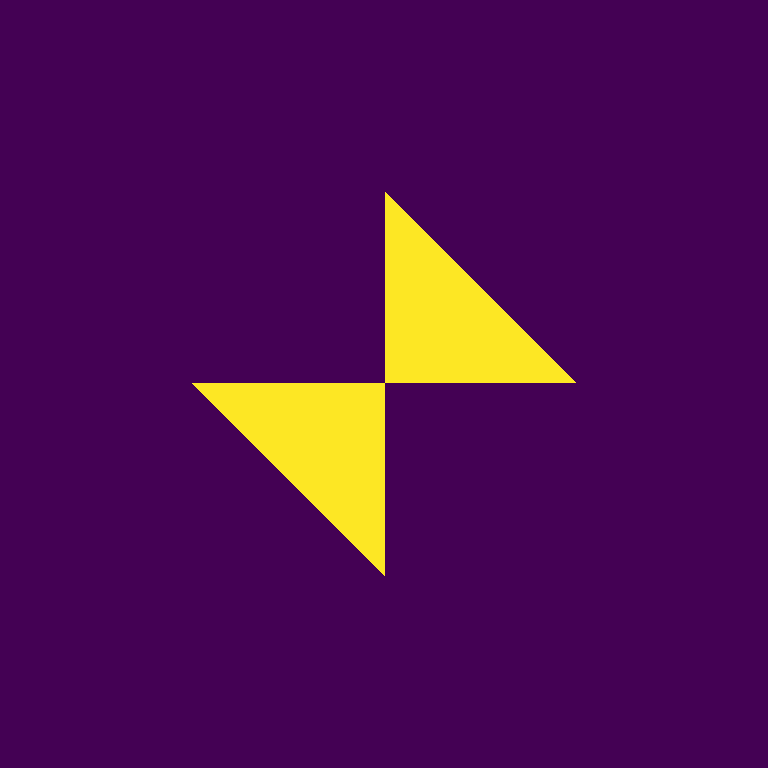

In [4]:
omega_a = cp.fft.fftfreq(768, 1.0)[..., np.newaxis]
omega_b = cp.fft.fftfreq(768, 1.0)[np.newaxis, ...]

mask_near = omega_a > 0
mask_far = omega_b > 0
mask_r = cp.abs(omega_a + omega_b) > 1.0/4

lpf = cp.logical_not(cp.logical_or(cp.logical_xor(mask_near, mask_far), mask_r)) * 1.0

display_image(cp.fft.fftshift(lpf).get())

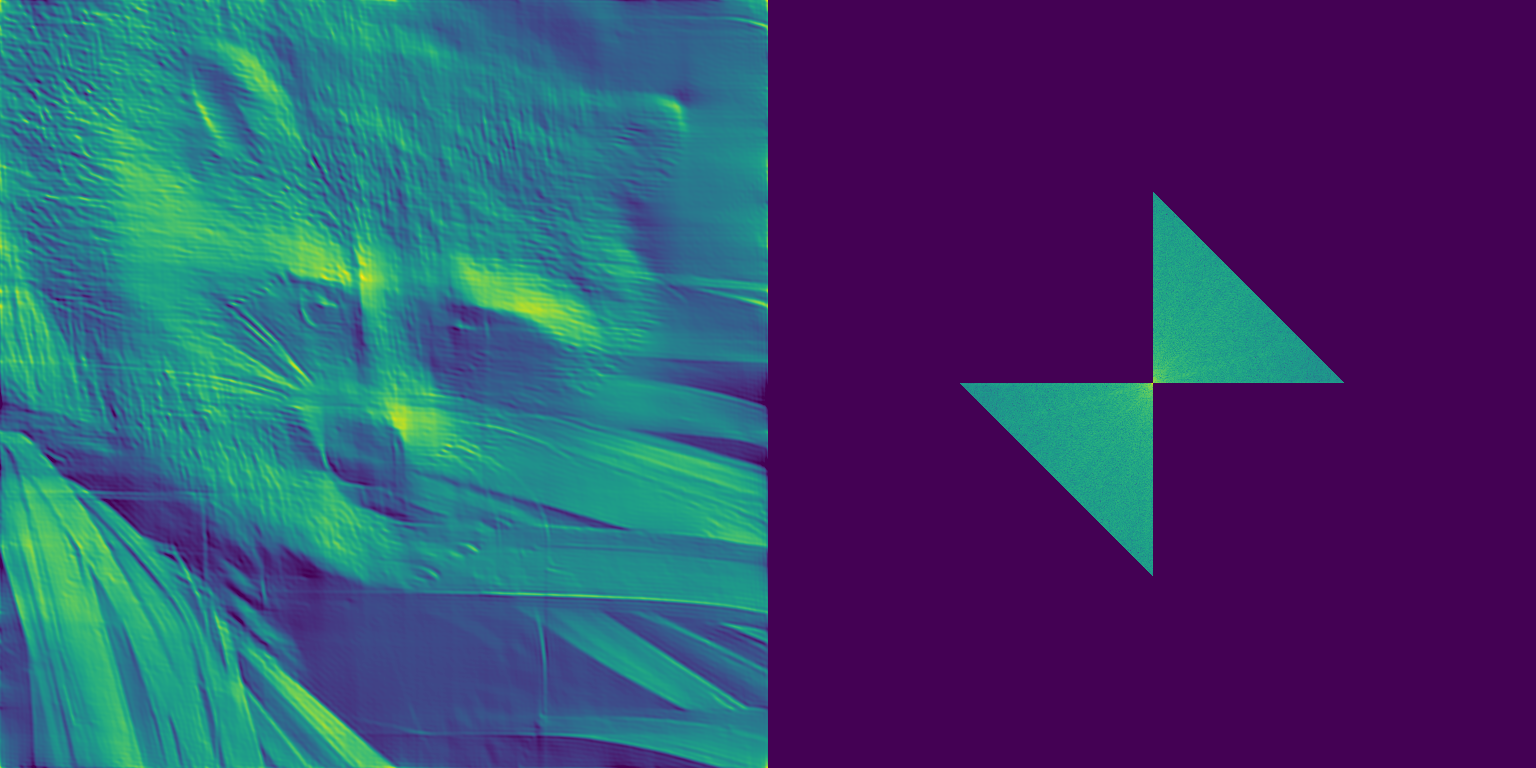

In [5]:
dual_filtered = dual * lpf
primal_filtered = cp.real(cp.fft.ifft2(dual_filtered))

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual_filtered))+1.0)
display_image(cp.vstack((primal_filtered/cp.amax(primal_filtered), spectrum/cp.amax(spectrum))).get())

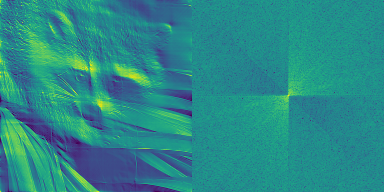

In [6]:
primal_downsampled = primal_filtered[::4, ::4]
dual_downsampled = cp.fft.fft2(primal_downsampled)

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual_downsampled))+1.0)
display_image(cp.vstack((primal_downsampled/cp.amax(primal_downsampled), spectrum/cp.amax(spectrum))).get())

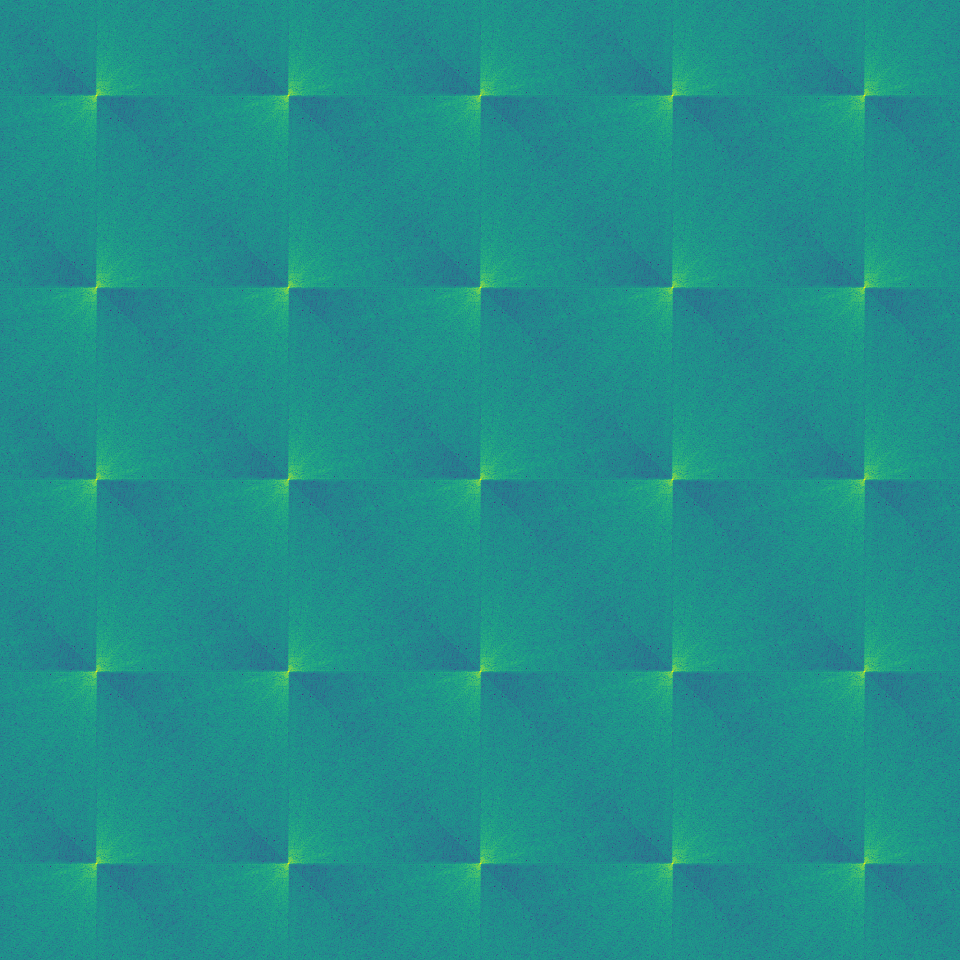

In [7]:
display_image(cp.tile(spectrum, (5, 5)).get())

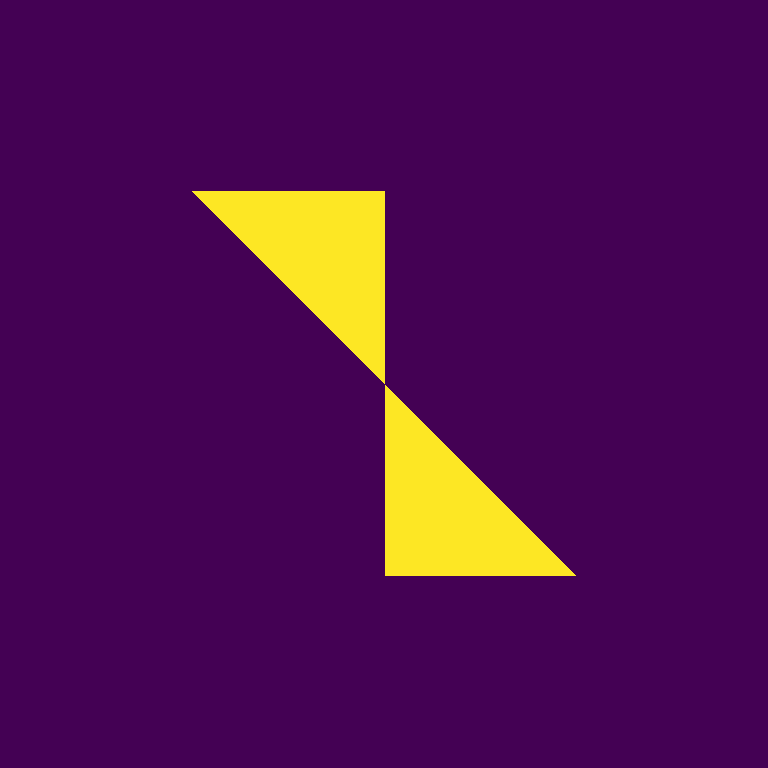

In [8]:
omega_a = cp.fft.fftfreq(768, 1.0)[..., np.newaxis]
omega_b = cp.fft.fftfreq(768, 1.0)[np.newaxis, ...]

mask_near = omega_a + omega_b < 0
mask_far = omega_a > 0
mask_r = cp.abs(omega_b) > 1.0/4

lpf = cp.logical_not(cp.logical_or(cp.logical_xor(mask_near, mask_far), mask_r)) * 1.0

display_image(cp.fft.fftshift(lpf).get())

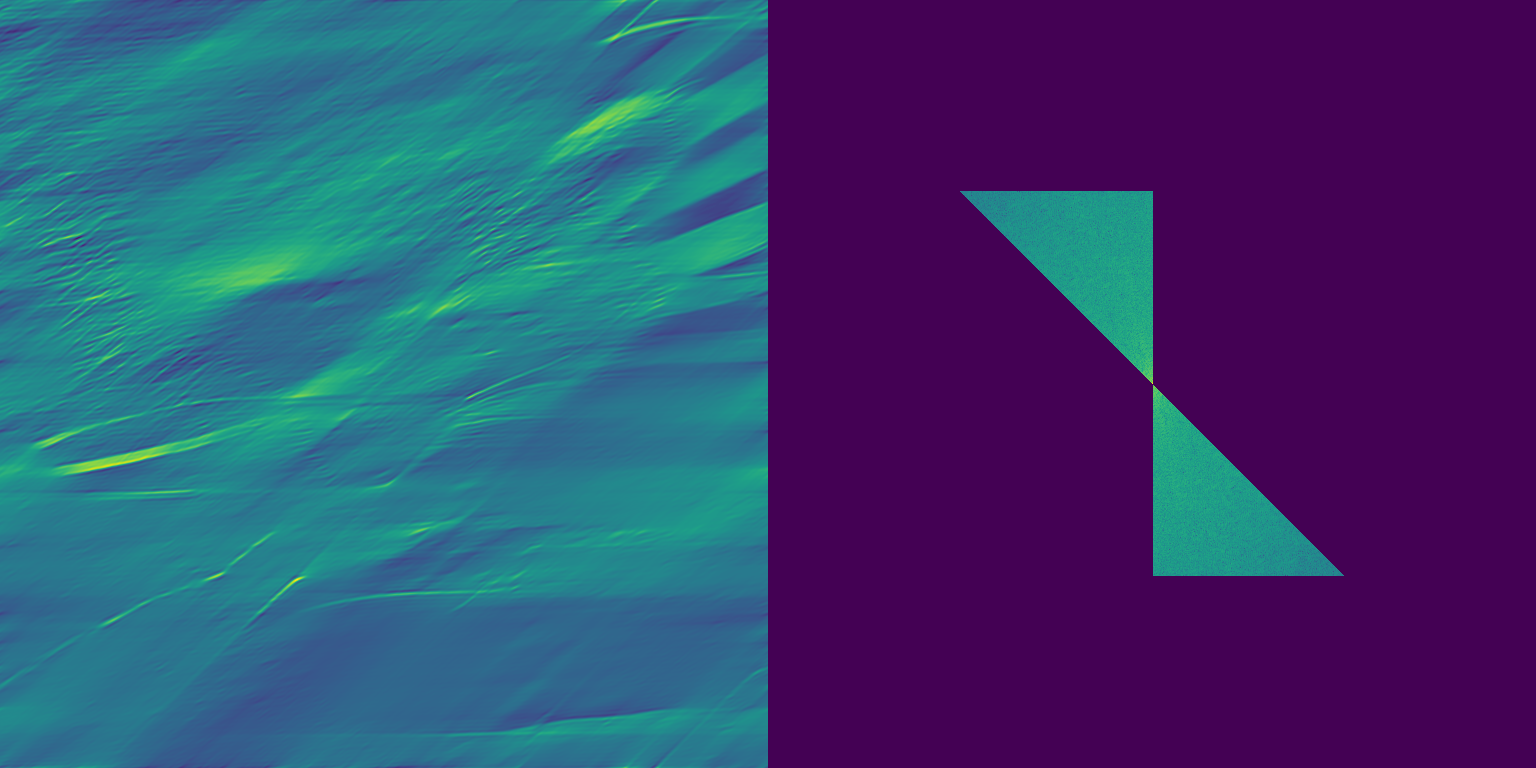

In [9]:
dual_filtered = dual * lpf
primal_filtered = cp.real(cp.fft.ifft2(dual_filtered))

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual_filtered))+1.0)
display_image(cp.vstack((primal_filtered/cp.amax(primal_filtered), spectrum/cp.amax(spectrum))).get())

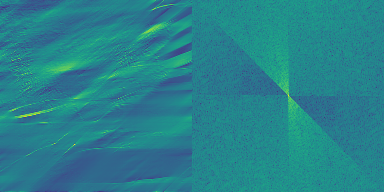

In [10]:
primal_downsampled = primal_filtered[::4, ::4]
dual_downsampled = cp.fft.fft2(primal_downsampled)

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual_downsampled))+1.0)
display_image(cp.vstack((primal_downsampled/cp.amax(primal_downsampled), spectrum/cp.amax(spectrum))).get())

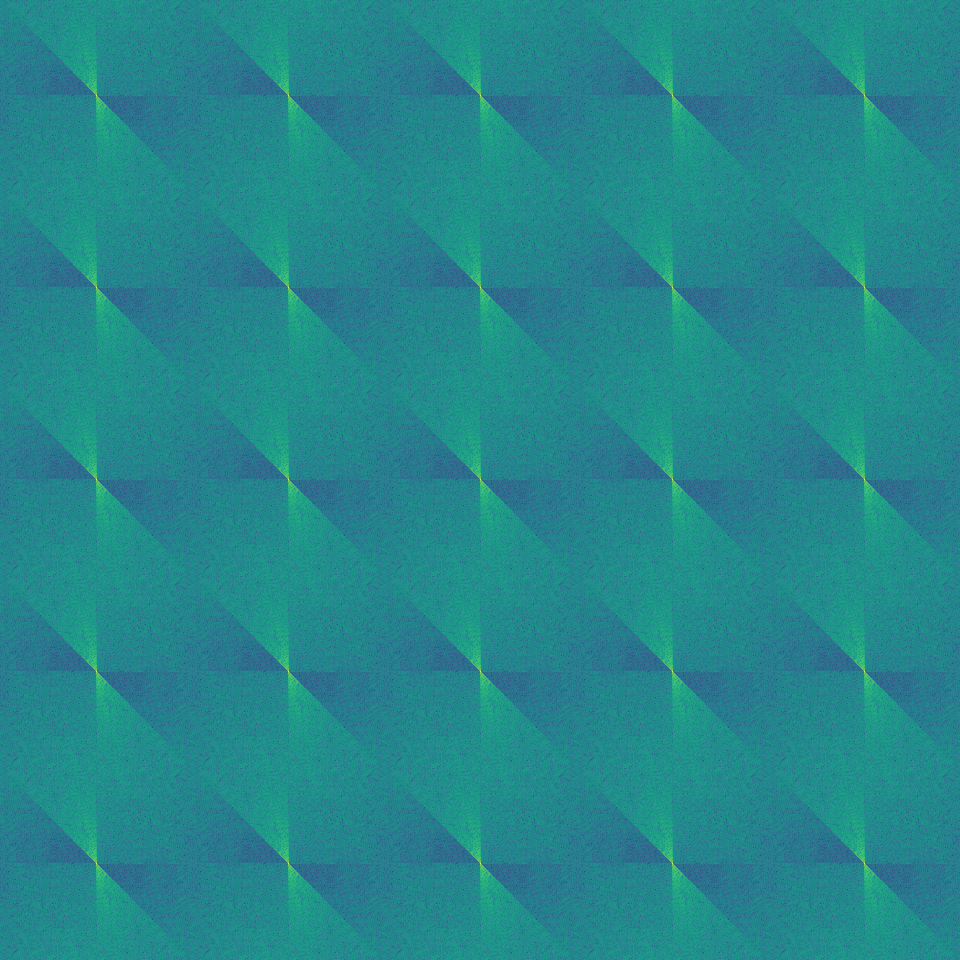

In [11]:
display_image(cp.tile(spectrum, (5, 5)).get())

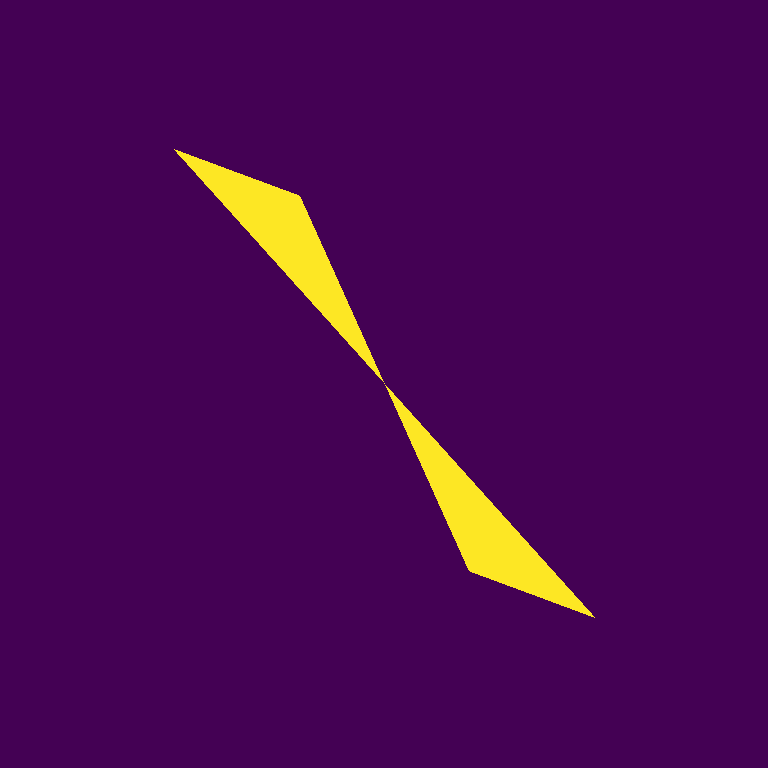

In [12]:
z_r = -17.0
z_a = 10.0
z_b = 30.0
z_near = 50.0
z_far = cp.inf

xi_r = 1.0

pitch_a, pitch_b = compute_display_pitch(z_r, z_a, z_b, z_near, z_far, xi_r)

omega_a = cp.fft.fftfreq(768, pitch_a/4)[..., np.newaxis]
omega_b = cp.fft.fftfreq(768, pitch_b/4)[np.newaxis, ...]

lpf = create_filter(omega_a, omega_b, z_r, z_a, z_b, z_near, z_far, xi_r)

display_image(cp.fft.fftshift(lpf).get())

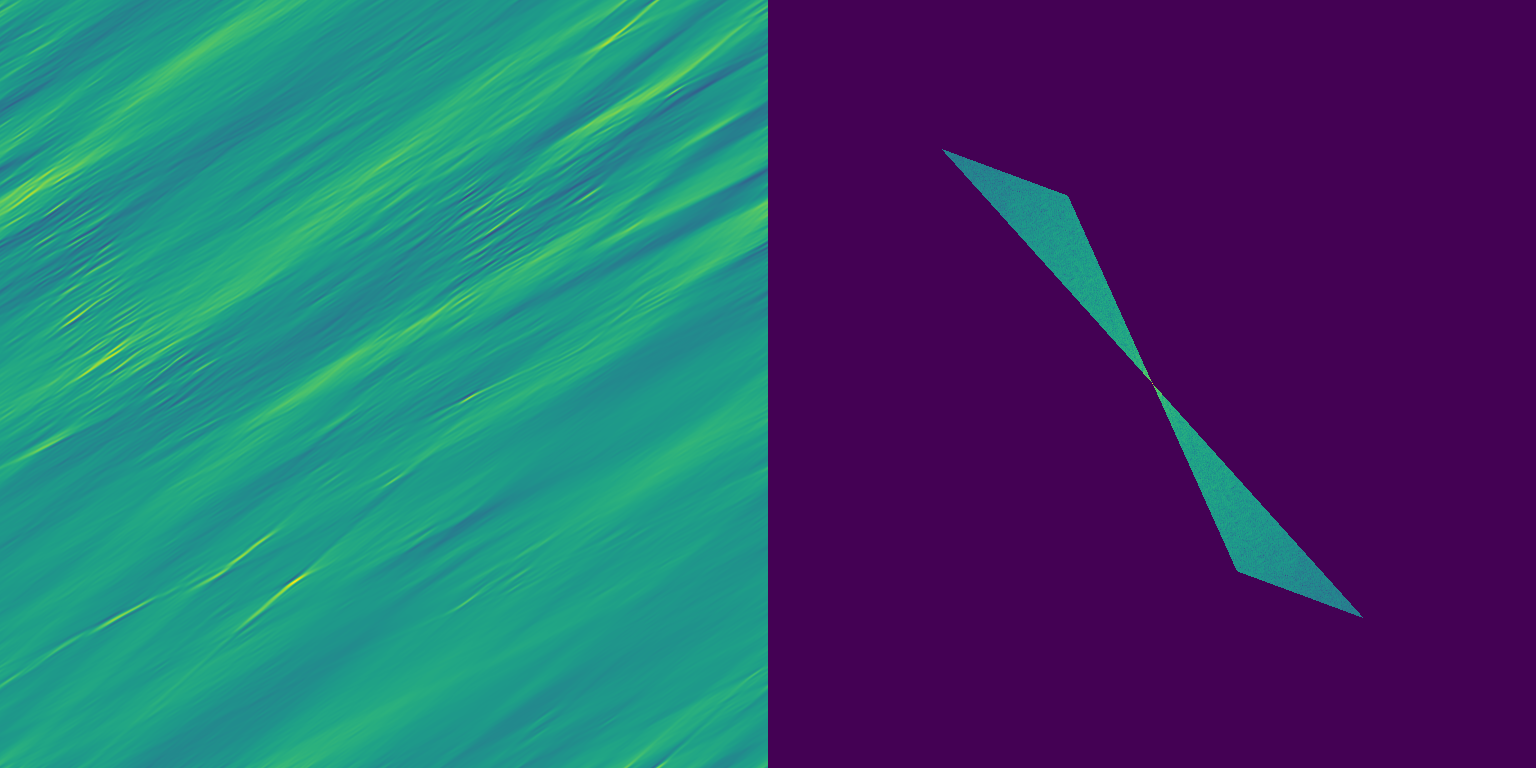

In [13]:
dual_filtered = dual * lpf
primal_filtered = cp.real(cp.fft.ifft2(dual_filtered))

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual_filtered))+1.0)
display_image(cp.vstack((primal_filtered/cp.amax(primal_filtered), spectrum/cp.amax(spectrum))).get())

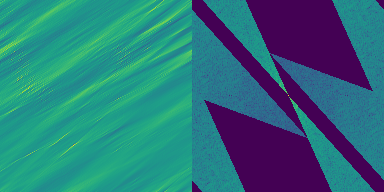

In [14]:
primal_downsampled = primal_filtered[::4, ::4]
dual_downsampled = cp.fft.fft2(primal_downsampled)

spectrum = cp.log(cp.abs(cp.fft.fftshift(dual_downsampled))+1.0)
display_image(cp.vstack((primal_downsampled/cp.amax(primal_downsampled), spectrum/cp.amax(spectrum))).get())

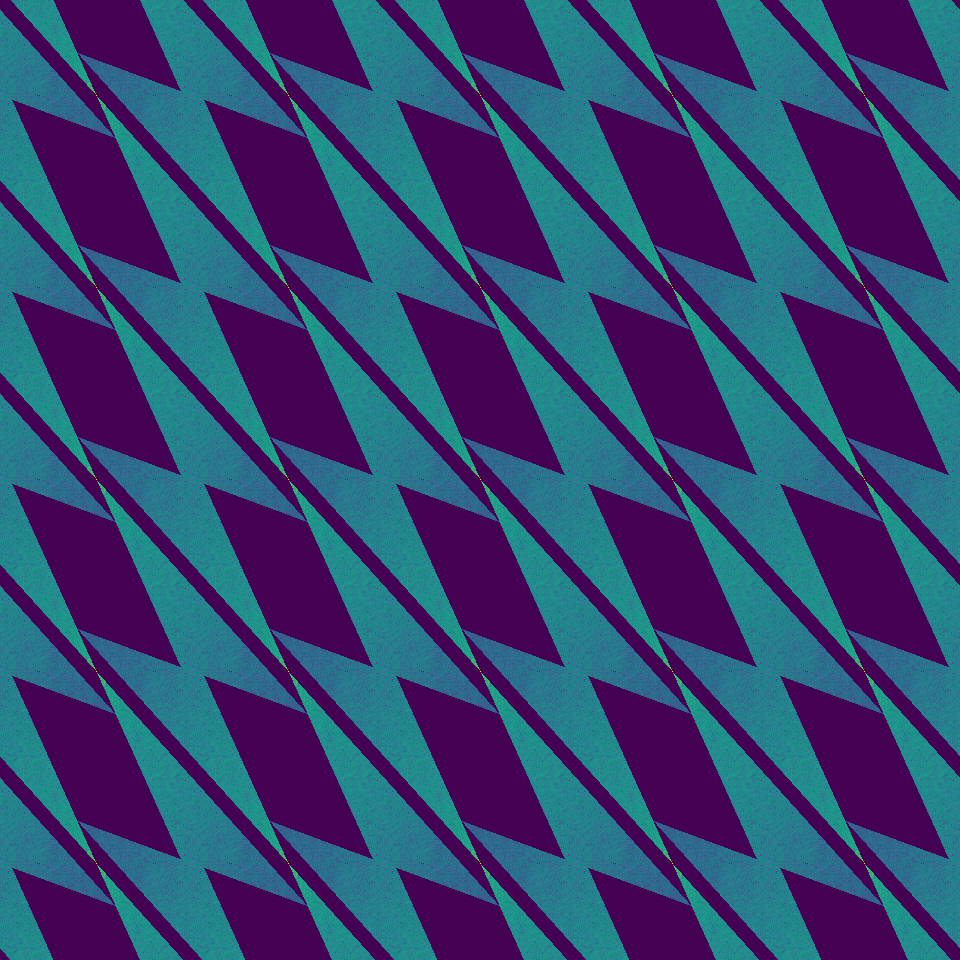

In [15]:
display_image(cp.tile(spectrum, (5, 5)).get())